In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from glob import glob
import seaborn as sns
from scipy import stats
import matplotlib.mlab as mlab
sns.set()
from astropy.wcs import WCS
from photutils import aperture_photometry,CircularAperture,CircularAnnulus
from astropy.stats import mad_std
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import photutils
#photutils.test()

C:\Users\Luke\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Luke\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


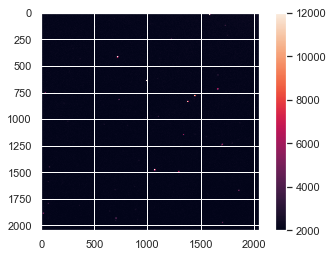

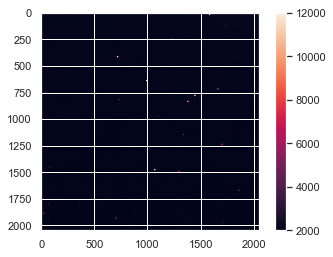

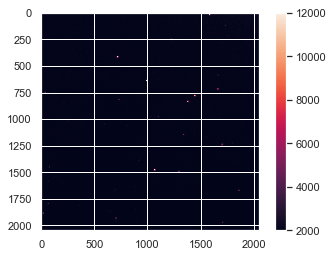

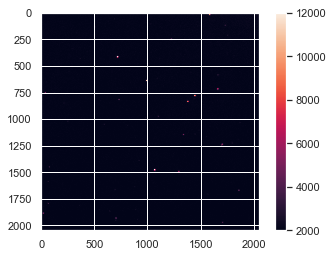

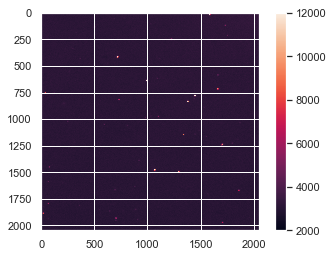

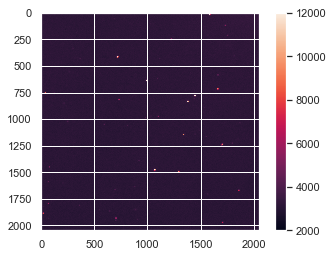

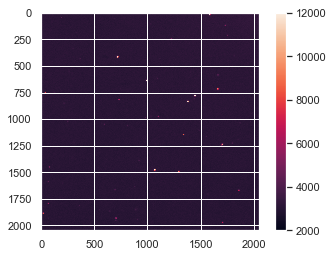

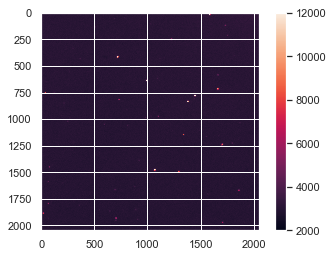

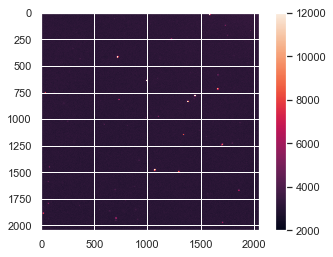

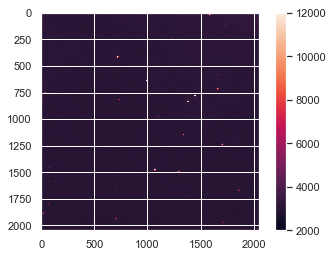

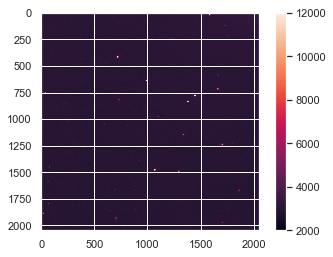

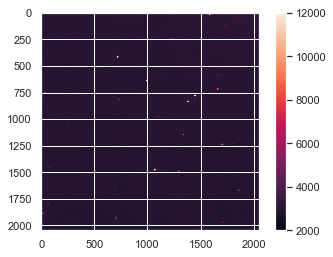

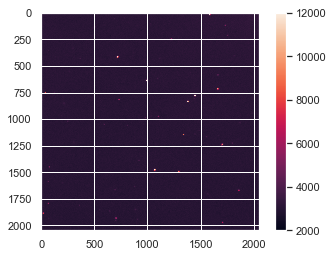

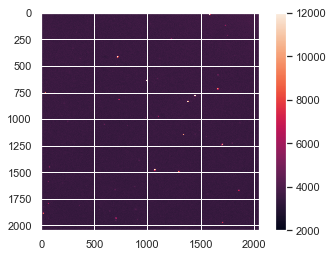

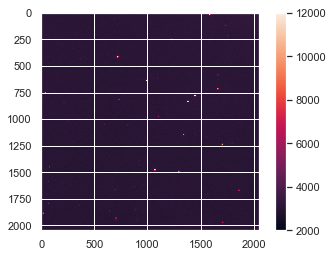

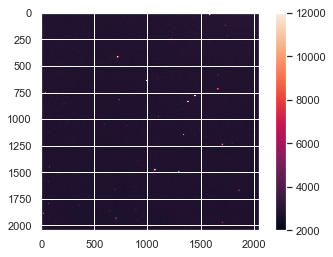

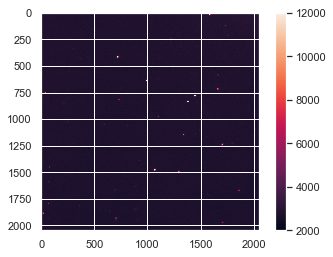

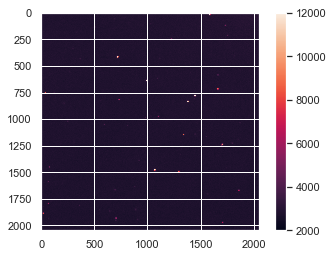

C:\Users\Luke\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


In [7]:
bias_files2 = glob('NNSer/bias/B*')
bias_data2 = [] 
for file in bias_files2: 
    image=fits.open(file) 
    bias_data2.append(image[0].data)

masterbias1 = np.average(bias_data2,axis=0)
flatN_files = glob('NNSer/flats/clear/F*') 
flatN_data = [] 

for file in flatN_files: 
    image=fits.open(file) 
    data = image[0].data 
    bias_sub = data - masterbias1
    flatN_data.append(bias_sub) 
    
masterflatn = np.average(flatN_data,axis=0)
nmasterflatn = masterflatn/((masterflatn[250:500,1250:1500]).mean())
objectN_files = glob('NNSer/object/clear/O*')


objectN_data = [] 
for file in objectN_files: 
    image=fits.open(file)
    objectN_data.append(image[0].data)
    
    
    
filtered=[]
for file in objectN_files:
    image=fits.open(file)
    values=image[0].data
    cobj=(values-masterbias1)/nmasterflatn
    rob=np.delete(cobj,np.s_[0:50],axis=1)
    filtered.append(rob)
    plt.imshow(rob,vmin=2000,vmax=12000)
    plt.colorbar()
    plt.show()
    
objectnnser = np.average(objectN_data,axis=0) 
correctednnser = ((objectnnser-masterbias1)/nmasterflatn) 
correctednnser = correctednnser[50:,50:]
newheader = fits.PrimaryHDU(correctednnser) 
newheader.writeto('CNN.fits',overwrite=True)

2858.097481204667


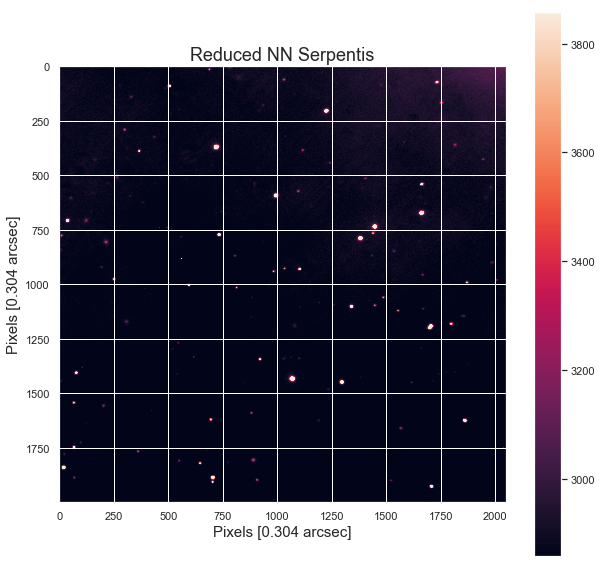

In [8]:
#print(correctedN)
print(np.mean(correctednnser))
plt.figure(figsize=[10,10]) 
plt.imshow(correctednnser,vmin=2858,vmax=3858)
plt.colorbar() 
plt.title('Reduced NN Serpentis',fontsize=18) 
plt.xlabel('Pixels [0.304 arcsec]',fontsize =15) 
plt.ylabel('Pixels [0.304 arcsec]',fontsize =15) 
plt.savefig('nnser.jpg')

In [14]:
image = fits.open('NNSer/Object/clear/O120308_0175.fits')
image = np.abs(image[0].data) 
bkg_sigma = mad_std(image)

daofind = DAOStarFinder(fwhm=6.,threshold=5.*bkg_sigma) 

sources=daofind(image)

sources


C:\Users\Luke\Anaconda3\lib\site-packages\photutils\detection\findstars.py:274: RuntimeWarning: overflow encountered in ulong_scalars
  sum2 = -quad1.sum() + quad2.sum() - quad3.sum() + quad4.sum()


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64
1,769.504500794471,421.2454601874722,0.41164930519529924,0.1890131733274072,-0.27906635478790764,49,0.0,35392.0,140.5614089113148,-5.369665254103393
2,89.05353898175403,757.6643670647037,0.4395071143519777,0.7219627996765189,-0.1443611819462519,49,0.0,8251.0,23.26647988180517,-3.4168267034306377
3,782.6235456771117,822.4700149604442,0.41523032336790716,0.8687518771184622,-0.2350222669279383,49,0.0,7216.0,19.12225512694445,-3.2038477705085455
4,862.8897784882897,1064.301406144701,0.23942707392011534,0.13941559036365303,0.04491963671651168,49,0.0,3126.0,2.689735550574121,-1.0742739578386638
5,1388.31706631117,1151.1408619891113,0.3849770021645021,0.934709351305813,-0.26854767433459237,49,0.0,6839.0,17.96721958236391,-3.1362021886734555
6,1117.4416775997945,1482.3309928102556,0.4088605057714481,0.20355426235244287,-0.2168834655367955,49,0.0,32943.0,117.62646700989849,-5.176262632221777
7,1344.7063647100492,1497.597077854422,0.4364189047889343,0.012592398265458866,-0.2781401621041524,49,0.0,11050.0,32.544195945912726,-3.7811838652542162
8,939.0533737894363,1854.9140517924636,0.27866291783817526,0.11236559139784946,-0.28608840717022754,49,0.0,3087.0,1.556089553115446,-0.4800864676636136
9,119.17817014927859,1936.0513925047846,0.47642574816487887,0.002521846226027799,0.1319221326435185,49,0.0,2950.0,1.7218585433098748,-0.5899936744384227


Text(0.5, 1.0, 'NN-Ser Master Image labelled')

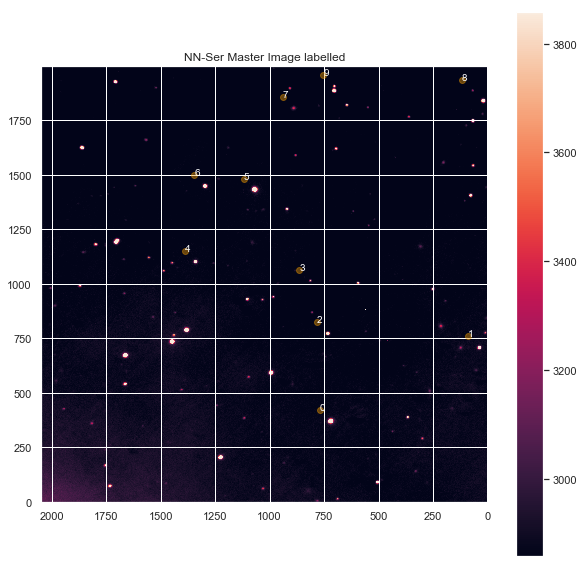

In [15]:
plt.figure(figsize=[10,10])

plt.imshow(correctednnser,vmin=2858,vmax=3858)
plt.colorbar()
plt.scatter(sources['xcentroid'],sources['ycentroid'],alpha=0.4,color='orange')

for i in range(0, len(sources)):
    plt.annotate(i, (sources['xcentroid'][i],sources['ycentroid'][i]), color = 'white')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title('NN-Ser Master Image labelled')
#plt.savefig('nnsermaster.jpg')

#some weird glow, try fix with bias?

In [16]:
results = [] 
times= [] 
nnsers= [] 
magerr=[]
for file in (objectN_files): 
    image = fits.open(file) 
    time = (image[0].header['UT']) 
    image = image[0].data
    
    positions = np.transpose((sources['xcentroid'],sources['ycentroid']))
    aperture = CircularAperture(positions,r=6) 
    annulus_aperture = CircularAnnulus(positions, r_in=10.,r_out=15.) 
    apers = [aperture,annulus_aperture]

    phot_table = aperture_photometry(image, apers)
   
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area

    bkg_sum = bkg_mean * aperture.area 

    final_sum = phot_table['aperture_sum_0']-bkg_sum 

    mag = -2.5*np.log10(final_sum)

    #print(magnitude)
    #four chosen zeropoints
    ZA = 15.8 - mag[39] 
    ZB = 15.1 - mag[59]
    ZC = 13.7 - mag[47] 
    ZD = 13.7 - mag[29]
    
    #mean zeropoint
    ZP = [ZA, ZB, ZC, ZD]

    mean_zpt, median_zpt, std_zpt = sigma_clipped_stats(ZP, sigma=2)

    nnser = magnitude[38]+mean_zpt
    
    magerr.append(magnitude[23])
    results.append([time, float(nnser)])
    times.append(time)
    nnsers.append(float(nnser))
    
print(results)

err = (max(magerr)-min(magerr))


TypeError: unsupported operand type(s) for /: 'float' and 'method'